## CMA-ES vs Gradient methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import cma
import time

### 1. Introduction
This notebook aims to explore how the Covariance Matrix Adaptation Evolution Strategy (CMA-ES), a powerful gradient-free optimization algorithm, can be used to "train" the weights of a simple neural network. We will apply it to a binary classification problem.

The primary goal is not to showcase CMA-ES as the best method for standard neural network training. Instead, it's to:

- Demonstrate that it can optimize neural network weights by directly optimizing for a metric like accuracy (which can be seen as a non-differentiable objective from a certain perspective).
- Critically compare its performance (accuracy, computational effort) against a standard gradient-based training method (like Adam, as used in scikit-learn's MLPClassifier).
- Encourage you to be "suspicious" and ask critical questions when you encounter non-gradient methods being used for standard, differentiable neural network training tasks where gradient-based methods are well-established and highly efficient.

### 2. The Dataset: Two Moons
We'll use the "Two Moons" dataset, a classic non-linearly separable binary classification problem.

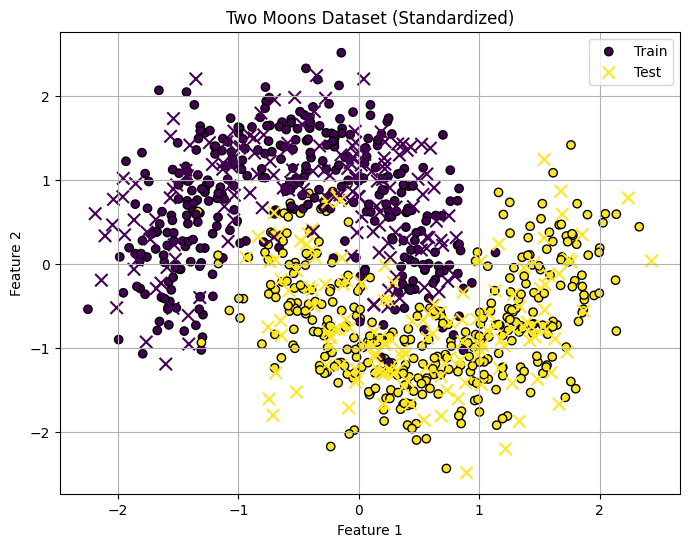

Training set shape: X=(700, 2), y=(700,)
Test set shape: X=(300, 2), y=(300,)


In [2]:
X, y = make_moons(n_samples=1000, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolors="k", label="Train"
)
plt.scatter(
    X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker="x", s=80, label="Test"
)
plt.title("Two Moons Dataset (Standardized)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

print(f"Training set shape: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test_scaled.shape}, y={y_test.shape}")

### 3. Neural Network Definition
We will use a simple feedforward neural network with:

Input layer: 2 neurons (for our 2D data) <br>
Hidden layer: N_HIDDEN neurons with tanh activation. You can start with `N_HIDDEN=32` <br>
Output layer: 1 neuron with sigmoid activation (for binary classification probability) <br>
The parameters (weights and biases) of this network will be flattened into a single vector for CMA-ES to optimize.

In [3]:
N_INPUT_NODES = X_train_scaled.shape[1]
N_HIDDEN_NODES = 128
N_OUTPUT_NODES = 1

# Calculate the total number of parameters (D)
# Weights W1: N_INPUT x N_HIDDEN
# Biases b1: N_HIDDEN
# Weights W2: N_HIDDEN x N_OUTPUT
# Biases b2: N_OUTPUT
D = (N_INPUT_NODES * N_HIDDEN_NODES) + N_HIDDEN_NODES + \
    (N_HIDDEN_NODES * N_OUTPUT_NODES) + N_OUTPUT_NODES

print(f"Neural Network Architecture:")
print(f"Input Layer: {N_INPUT_NODES} neurons")
print(f"Hidden Layer: {N_HIDDEN_NODES} neurons (tanh activation)")
print(f"Output Layer: {N_OUTPUT_NODES} neuron (sigmoid activation)")
print(f"Total number of parameters (weights & biases) to optimize: D = {D}")

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def nn_forward_pass(params_vector: np.ndarray, X_data: np.ndarray) -> np.ndarray:
    idx_end_W1 = N_INPUT_NODES * N_HIDDEN_NODES
    W1 = params_vector[0:idx_end_W1].reshape(N_INPUT_NODES, N_HIDDEN_NODES)

    idx_end_b1 = idx_end_W1 + N_HIDDEN_NODES
    b1 = params_vector[idx_end_W1:idx_end_b1]

    idx_end_W2 = idx_end_b1 + (N_HIDDEN_NODES * N_OUTPUT_NODES)
    W2 = params_vector[idx_end_b1:idx_end_W2].reshape(N_HIDDEN_NODES, N_OUTPUT_NODES)

    b2 = params_vector[idx_end_W2:]

    # Hidden layer
    hidden_layer_input = np.dot(X_data, W1) + b1
    hidden_layer_output = tanh(hidden_layer_input)

    # Output layer
    output_layer_input = np.dot(hidden_layer_output, W2) + b2
    output = sigmoid(output_layer_input)

    return output

Neural Network Architecture:
Input Layer: 2 neurons
Hidden Layer: 128 neurons (tanh activation)
Output Layer: 1 neuron (sigmoid activation)
Total number of parameters (weights & biases) to optimize: D = 513


### 4. Training with CMA-ES
We have to define a fitness function that CMA-ES will try to minimize. Since our goal is to maximize accuracy, our fitness will be 1.0 - accuracy.

The accuracy is calculated by:
- Performing a forward pass with the given parameters.
- Thresholding the sigmoid output (e.g., > 0.5 means class 1, else class 0).
- Comparing predicted classes to true labels.
- This direct use of accuracy (based on a hard threshold) makes the objective effectively non-differentiable with respect to the network parameters if one were to try to use calculus directly without a surrogate like cross-entropy.

In [5]:
def fitness_function(params_vector: np.ndarray) -> float:
    predictions = nn_forward_pass(params_vector, X_train_scaled)
    
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    
    accuracy = np.mean(predicted_classes == y_train)
    
    return 1.0 - accuracy

In [7]:
initial_params = np.random.randn(D)
sigma = 0.5

es = cma.CMAEvolutionStrategy(initial_params, sigma)
while not es.stop():
    solutions = es.ask()
    fitness_values = [fitness_function(sol) for sol in solutions]
    es.tell(solutions, fitness_values)

best_params_cma = es.result.xbest

(11_w,22)-aCMA-ES (mu_w=6.5,w_1=26%) in dimension 513 (seed=746963, Thu May  8 08:24:08 2025)


### Visualizing the Decision Boundary (CMA-ES)
Let's see how the decision boundary learned by the CMA-ES-trained network looks.

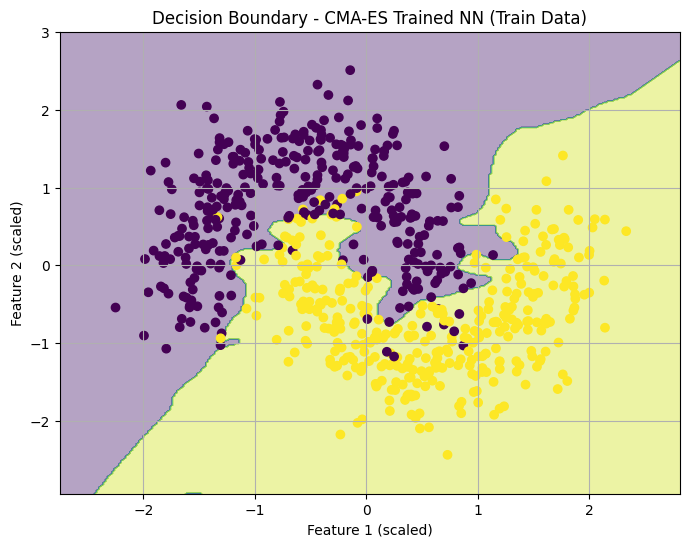

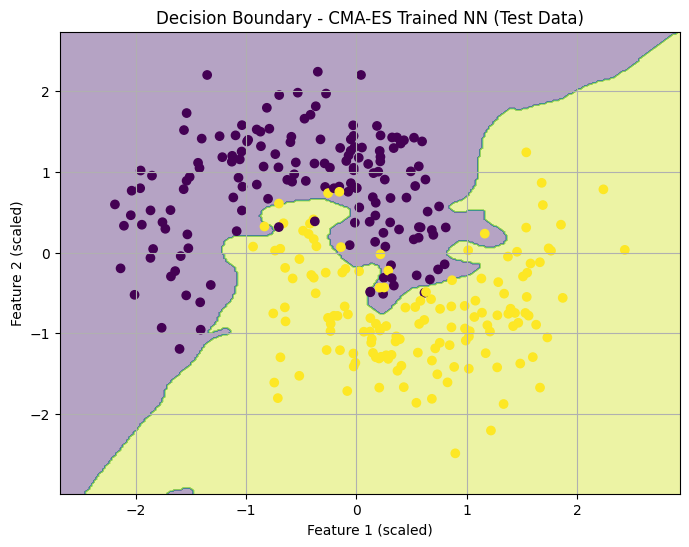

In [8]:
def plot_decision_boundary(pred_func, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z_proba = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = (Z_proba > 0.5).astype(int)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title(title)
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.grid(True)
    plt.show()

cma_pred_func = lambda x_data: nn_forward_pass(best_params_cma, x_data)

plot_decision_boundary(cma_pred_func, X_train_scaled, y_train, "Decision Boundary - CMA-ES Trained NN (Train Data)")
plot_decision_boundary(cma_pred_func, X_test_scaled, y_test, "Decision Boundary - CMA-ES Trained NN (Test Data)")

### 5. Training with a Standard Gradient-Based Method
Now, let's train a neural network with the same architecture using a standard gradient-based optimizer. You can use `scikit-learn`'s MLPClassifier, which employs optimizers like 'adam' or 'sgd' and uses a differentiable loss function (like cross-entropy) internally. Display decision boundary for a trained model.

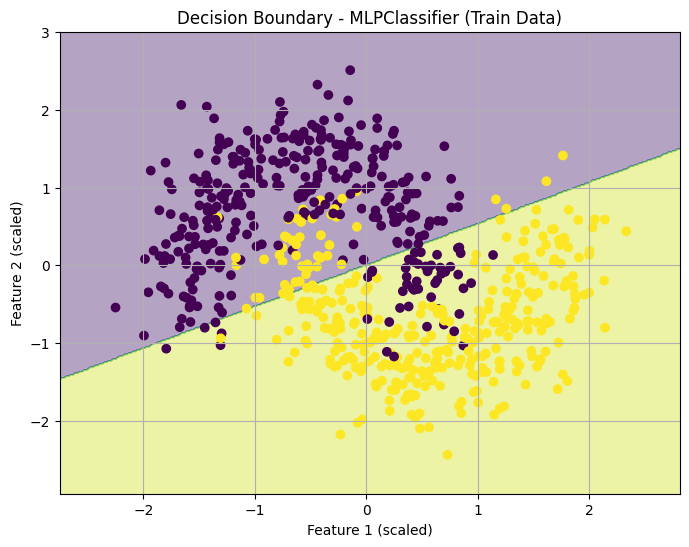

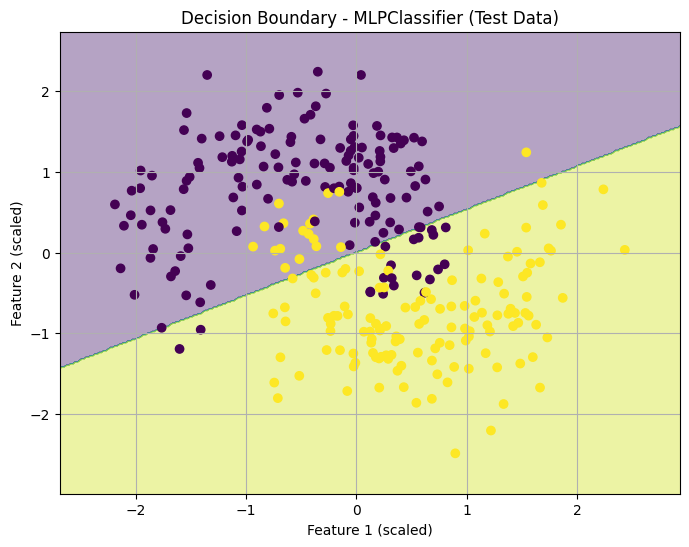

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(N_HIDDEN_NODES,), activation='tanh', solver='adam', max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

mlp_pred_func = lambda x_data: mlp.predict_proba(x_data)[:, 1]

plot_decision_boundary(mlp_pred_func, X_train_scaled, y_train, "Decision Boundary - MLPClassifier (Train Data)")
plot_decision_boundary(mlp_pred_func, X_test_scaled, y_test, "Decision Boundary - MLPClassifier (Test Data)")

### Exercise 1

Compare the performance of CMA-ES and MLPClassifier across varying hidden layer sizes (e.g., 8, 16, 32, 64). Evaluate both methods in terms of training time and the quality of the resulting models, using appropriate performance metrics.

In [ ]:
from time import time
from sklearn.metrics import accuracy_score

hidden_layer_sizes = [8, 16, 32, 64]

results = []

for n_hidden in hidden_layer_sizes:

    N_HIDDEN_NODES = n_hidden
    D = (N_INPUT_NODES * N_HIDDEN_NODES) + N_HIDDEN_NODES + \
        (N_HIDDEN_NODES * N_OUTPUT_NODES) + N_OUTPUT_NODES

    start_time = time()
    initial_params = np.random.randn(D)
    es = cma.CMAEvolutionStrategy(initial_params, sigma)
    while not es.stop():
        solutions = es.ask()
        fitness_values = [fitness_function(sol) for sol in solutions]
        es.tell(solutions, fitness_values)
    best_params_cma = es.result.xbest
    cma_time = time() - start_time

    cma_pred_train = (nn_forward_pass(best_params_cma, X_train_scaled) > 0.5).astype(int).flatten()
    cma_pred_test = (nn_forward_pass(best_params_cma, X_test_scaled) > 0.5).astype(int).flatten()
    cma_train_acc = accuracy_score(y_train, cma_pred_train)
    cma_test_acc = accuracy_score(y_test, cma_pred_test)

    start_time = time()
    mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), activation='tanh', solver='adam', max_iter=1000, random_state=42)
    mlp.fit(X_train_scaled, y_train)
    mlp_time = time() - start_time

    mlp_train_acc = mlp.score(X_train_scaled, y_train)
    mlp_test_acc = mlp.score(X_test_scaled, y_test)

    results.append({
        'hidden_layer_size': n_hidden,
        'cma_train_acc': cma_train_acc,
        'cma_test_acc': cma_test_acc,
        'cma_time': cma_time,
        'mlp_train_acc': mlp_train_acc,
        'mlp_test_acc': mlp_test_acc,
        'mlp_time': mlp_time
    })

for result in results:
    print(f"Hidden Layer Size: {result['hidden_layer_size']}")
    print(f"CMA-ES - Train Acc: {result['cma_train_acc']:.4f}, Test Acc: {result['cma_test_acc']:.4f}, Time: {result['cma_time']:.2f}s")
    print(f"MLP - Train Acc: {result['mlp_train_acc']:.4f}, Test Acc: {result['mlp_test_acc']:.4f}, Time: {result['mlp_time']:.2f}s")
    print("-" * 50)

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 33 (seed=840184, Thu May  8 08:34:25 2025)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 65 (seed=803538, Thu May  8 08:34:26 2025)
(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 129 (seed=787388, Thu May  8 08:34:29 2025)
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 257 (seed=744067, Thu May  8 08:34:40 2025)
Hidden Layer Size: 8
CMA-ES - Train Acc: 0.9586, Test Acc: 0.9567, Time: 0.39s
MLP - Train Acc: 0.9343, Test Acc: 0.9300, Time: 0.37s
--------------------------------------------------
Hidden Layer Size: 16
CMA-ES - Train Acc: 0.9586, Test Acc: 0.9567, Time: 2.56s
MLP - Train Acc: 0.8571, Test Acc: 0.8633, Time: 0.10s
--------------------------------------------------
Hidden Layer Size: 32
CMA-ES - Train Acc: 0.9671, Test Acc: 0.9600, Time: 11.38s
MLP - Train Acc: 0.8586, Test Acc: 0.8667, Time: 0.08s
--------------------------------------------------
Hidden Layer Size: 64
CMA-ES - Train Acc: 0.9671, Test Acc: 0.9633, Time: 88.52s
MLP - Train Acc: 0.8557, Test Acc: 0.8667, Time: 0.19s
---------------------------

### Exercise 2
Read the article titled "Artykuł" available on UPeL, and provide a critical analysis of its content.

Article present and states that they have "Superior results in experiments in plenty datasets" but it seems to be a bit misleading. Tests was made on pretty known and simple datasets like Iris, Diabetes, and Wine. Which number of features is small. 

In example of Horse dataset where number of features was around 27 the results was not that "superior".

Strange is that they present many types of neural network like Particle Swarm OptimizationNN, Torus SeqNN, and others but accuracy on each was somewhat similar. There was not outsanding neural network apart from the others. It could be due that these are random methods so could be quite similar and maybe they are not that different from each other.

Parameters are strange presented, we are not sure how to reuse them or reproduce the algorithm later.

Standard PSO Algorithm pseudo code is not very clear, lacks of explanation of variables.

Some articles are not related that much.